In [1]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from alphabet_detector import AlphabetDetector
import unicodedata
from langdetect import detect
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
import pinyin
from unidecode import unidecode
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('stopwords')

cnchar_df = pd.read_excel('name_data/exigerData/EXGR_Chinese names(Character).xlsx')
cnrom_df = pd.read_excel("name_data/exigerData/EXGR_Chinese names(Romantized).xlsx")
viet_df = pd.read_excel("name_data/exigerData/EXGR_Vietnamese.xlsx")

pd.set_option('display.max_columns', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joliehuang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#FUNCTIONS

#alphabet
def langname(name):
    if isinstance(name, str):
        result = []
        for char in name:
            try:
                char_name = unicodedata.name(char).split(' ')[0]
                result.append(char_name)
            except ValueError:
                # Handle characters without Unicode names
                result.append(char)
        return result
    else:
        return None  # Handle non-string or NaN values

#num_tokens (how many parts to the name?)
def calculate_token_length(name):
    if isinstance(name, str):
        # Check if the name contains Chinese characters
        if any('\u4e00' <= char <= '\u9fff' for char in name):
            # For Chinese names, count characters
            return len(name)
        else:
            # For non-Chinese names, split by spaces and count words
            return len(name.split())
    else:
        return None  # Handle non-string or NaN values

#char_ngrams
def generate_char_ngrams(text):
    if isinstance(text, str):
        # Tokenize the text into words
        words = text.split()
        
        # Create unigrams, bigrams, and trigrams
        unigrams = list(ngrams(text, 1))
        bigrams = list(ngrams(text, 2))
        trigrams = list(ngrams(text, 3))
        
        # Interpolated n-grams (combining unigrams, bigrams, and trigrams)
        interpolated_ngrams = unigrams + bigrams + trigrams
        
        return interpolated_ngrams
    else:
        return []

#name_length (length of the entire name string)
def get_name_length(fullname):
    if isinstance(fullname, str):
        return len(fullname)
    else:
        return np.nan 

#unigrams
def generate_char_unigrams(text):
    if isinstance(text, str):
        # Tokenize the text into characters
        characters = list(text)
        
        # Create unigrams
        unigrams = list(ngrams(characters, 1))
        
        return unigrams
    else:
        return []

#bigrams
def generate_char_bigrams(text):
    if isinstance(text, str):
        # Tokenize the text into characters
        characters = list(text)
        
        # Create unigrams
        bigrams = list(ngrams(characters, 2))
        
        return bigrams
    else:
        return []

#trigrams
def generate_char_trigrams(text):
    if isinstance(text, str):
        # Tokenize the text into characters
        characters = list(text)
        
        # Create unigrams
        trigrams = list(ngrams(characters, 3))
        
        return trigrams
    else:
        return []

# Function to transliterate a Chinese name
def transliterate_name(name):
    return pinyin.get(name, format="strip", delimiter=" ")


EXGR_Chinese names(Character).xlsx - CLEANING
===

In [3]:
pd.set_option('display.max_columns', None)
# cnchar_df

In [4]:
duplicates = cnchar_df['fullname'].duplicated()
# print(cnchar_df[duplicates])

In [5]:
cnchar_df.drop_duplicates(subset=['fullname'], keep='first', inplace=True)
# cnchar_df

In [6]:
# null_values = cnchar_df['fullname'].isnull()
# print(cnchar_df[null_values])
# NO NULL VALUES

DATA EXPLORATION

In [7]:
# cnchar_df['Notes'].unique()

**Maybe notes saying that it's a minority name/non-native name should be counted? Drop all the ones that say pseudonym/stage name? Maybe we can afford to drop certain examples of names, since we have so many of them...?

In [8]:
drop_notes = ['minority name', 'non-native', 'pseudonym', 'stage name',
       'should be侯赛因.江；minority name',
       '劉-family name of her husband;吳-her family name', 'satage name',
       '周-family name of her husband;梁-her family name', 'fake name',
       'pen name', '方-family name of her husband; 黄-her family name',
       '曹-family name of her husband;王-her family name',
       '朱-family name of her husband;李-her family name',
       '朱-family name of her husband;葉-her family name',
       '林-family name of her husband;鄭-her family name',
       '梁-family name of her husband;劉- her family name ',
       '梁-family name of her husband;高- her family name',
       'should be 泰迪.羅賓；non-native',
       '罗-family name of her husband;范-her family name',
       '范-family name of her husband;徐-her family name',
       '葉-family name of her husband；劉-her family name',
       '蘇-family name of her husband;周- her family name', 'buddhist',
       'family name should be in Chinese character 周',
       '陈-family name of her husband; 冯-her family name',
       '陳-family name of her husband;方-her family name',
       '高-family name of her husband;金-her family name',
       '黃-family name of her husband;馬-her family name']

cnchar_df = cnchar_df[~cnchar_df['Notes'].isin(drop_notes)]
# cnchar_df

In [9]:
# cnchar_df['Notes'].unique()

In [10]:
# cnchar_df['Unnamed: 6'].unique()

In [11]:
cnchar_df.drop(columns = ['Unnamed: 0', 'id', 'Family name', 'Given Name', 'Notes' ,'Unnamed: 6'], inplace = True)
# cnchar_df

Feature Engineering (Chinese Character)

In [12]:
cnchar_df['alphabet'] = cnchar_df['fullname'].apply(langname)
# cnchar_df

In [13]:
cnchar_df['word_length'] = cnchar_df['fullname'].apply(get_name_length)
# cnchar_df

In [14]:
cnchar_df['num_tokens'] = cnchar_df['fullname'].apply(calculate_token_length)
# cnchar_df

In [15]:
cnchar_df['char_ngrams'] = cnchar_df['fullname'].apply(generate_char_ngrams)
# cnchar_df

In [16]:
cnchar_df['unigrams'] = cnchar_df['fullname'].apply(generate_char_unigrams)
cnchar_df['bigrams'] = cnchar_df['fullname'].apply(generate_char_bigrams)
cnchar_df['trigrams'] = cnchar_df['fullname'].apply(generate_char_trigrams)
# cnchar_df

In [17]:
cnchar_df['period_freq'] = cnchar_df['fullname'].apply(lambda name: name.count('.'))
cnchar_df['dash_freq'] = cnchar_df['fullname'].apply(lambda name: name.count('-'))
cnchar_df['space_freq'] = cnchar_df['fullname'].apply(lambda name: name.count(' '))
cnchar_df['apostrophe_freq'] = cnchar_df['fullname'].apply(lambda name: name.count('\''))
# cnchar_df

In [18]:
cnchar_df['transliteration'] = cnchar_df['fullname'].apply(transliterate_name)
cnchar_df

,fullname,alphabet,word_length,num_tokens,char_ngrams,unigrams,bigrams,trigrams,period_freq,dash_freq,space_freq,apostrophe_freq,transliteration
0,丁一平,"[CJK, CJK, CJK]",3,3,"[(丁,), (一,), (平,), (丁, 一), (一, 平), (丁, 一, 平)]","[(丁,), (一,), (平,)]","[(丁, 一), (一, 平)]","[(丁, 一, 平)]",0,0,0,0,ding yi ping
1,丁世雄,"[CJK, CJK, CJK]",3,3,"[(丁,), (世,), (雄,), (丁, 世), (世, 雄), (丁, 世, 雄)]","[(丁,), (世,), (雄,)]","[(丁, 世), (世, 雄)]","[(丁, 世, 雄)]",0,0,0,0,ding shi xiong
2,丁亦昕,"[CJK, CJK, CJK]",3,3,"[(丁,), (亦,), (昕,), (丁, 亦), (亦, 昕), (丁, 亦, 昕)]","[(丁,), (亦,), (昕,)]","[(丁, 亦), (亦, 昕)]","[(丁, 亦, 昕)]",0,0,0,0,ding yi xin
3,丁仲礼,"[CJK, CJK, CJK]",3,3,"[(丁,), (仲,), (礼,), (丁, 仲), (仲, 礼), (丁, 仲, 礼)]","[(丁,), (仲,), (礼,)]","[(丁, 仲), (仲, 礼)]","[(丁, 仲, 礼)]",0,0,0,0,ding zhong li
4,丁伟,"[CJK, CJK]",2,2,"[(丁,), (伟,), (丁, 伟)]","[(丁,), (伟,)]","[(丁, 伟)]",[],0,0,0,0,ding wei
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12038,龚翔宇,"[CJK, CJK, CJK]",3,3,"[(龚,), (翔,), (宇,), (龚, 翔), (翔, 宇), (龚, 翔, 宇)]","[(龚,), (翔,), (宇,)]","[(龚, 翔), (翔, 宇)]","[(龚, 翔, 宇)]",0,0,0,0,gong xiang yu
12039,龚育之,"[CJK, CJK, CJK]",3,3,"[(龚,), (育,), (之,), (龚, 育), (育, 之), (龚, 育, 之)]","[(龚,), (育,), (之,)]","[(龚, 育), (育, 之)]","[(龚, 育, 之)]",0,0,0,0,gong yu zhi
12040,龚蓓苾,"[CJK, CJK, CJK]",3,3,"[(龚,), (蓓,), (苾,), (龚, 蓓), (蓓, 苾), (龚, 蓓, 苾)]","[(龚,), (蓓,), (苾,)]","[(龚, 蓓), (蓓, 苾)]","[(龚, 蓓, 苾)]",0,0,0,0,gong bei bi
12041,龚贤永,"[CJK, CJK, CJK]",3,3,"[(龚,), (贤,), (永,), (龚, 贤), (贤, 永), (龚, 贤, 永)]","[(龚,), (贤,), (永,)]","[(龚, 贤), (贤, 永)]","[(龚, 贤, 永)]",0,0,0,0,gong xian yong


In [19]:
cnchar_df['t.alphabet'] = cnchar_df['transliteration'].apply(langname)
# cnchar_df
cnchar_df['t.word_length'] = cnchar_df['transliteration'].apply(get_name_length)
# cnchar_df
cnchar_df['t.num_tokens'] = cnchar_df['transliteration'].apply(calculate_token_length)
# cnchar_df
cnchar_df['t.char_ngrams'] = cnchar_df['transliteration'].apply(generate_char_ngrams)
# cnchar_df
cnchar_df['t.unigrams'] = cnchar_df['transliteration'].apply(generate_char_unigrams)
cnchar_df['t.bigrams'] = cnchar_df['transliteration'].apply(generate_char_bigrams)
cnchar_df['t.trigrams'] = cnchar_df['transliteration'].apply(generate_char_trigrams)
# cnchar_df
cnchar_df['t.period_freq'] = cnchar_df['transliteration'].apply(lambda name: name.count('.'))
cnchar_df['t.dash_freq'] = cnchar_df['transliteration'].apply(lambda name: name.count('-'))
cnchar_df['t.space_freq'] = cnchar_df['transliteration'].apply(lambda name: name.count(' '))
cnchar_df['t.apostrophe_freq'] = cnchar_df['transliteration'].apply(lambda name: name.count('\''))
# cnchar_df
cnchar_df

,fullname,alphabet,word_length,num_tokens,char_ngrams,unigrams,bigrams,trigrams,period_freq,dash_freq,space_freq,apostrophe_freq,transliteration,t.alphabet,t.word_length,t.num_tokens,t.char_ngrams,t.unigrams,t.bigrams,t.trigrams,t.period_freq,t.dash_freq,t.space_freq,t.apostrophe_freq
0,丁一平,"[CJK, CJK, CJK]",3,3,"[(丁,), (一,), (平,), (丁, 一), (一, 平), (丁, 一, 平)]","[(丁,), (一,), (平,)]","[(丁, 一), (一, 平)]","[(丁, 一, 平)]",0,0,0,0,ding yi ping,"[LATIN, LATIN, LATIN, LATIN, SPACE, LATIN, LAT...",12,3,"[(d,), (i,), (n,), (g,), ( ,), (y,), (i,), ( ,...","[(d,), (i,), (n,), (g,), ( ,), (y,), (i,), ( ,...","[(d, i), (i, n), (n, g), (g, ), ( , y), (y, i...","[(d, i, n), (i, n, g), (n, g, ), (g, , y), (...",0,0,2,0
1,丁世雄,"[CJK, CJK, CJK]",3,3,"[(丁,), (世,), (雄,), (丁, 世), (世, 雄), (丁, 世, 雄)]","[(丁,), (世,), (雄,)]","[(丁, 世), (世, 雄)]","[(丁, 世, 雄)]",0,0,0,0,ding shi xiong,"[LATIN, LATIN, LATIN, LATIN, SPACE, LATIN, LAT...",14,3,"[(d,), (i,), (n,), (g,), ( ,), (s,), (h,), (i,...","[(d,), (i,), (n,), (g,), ( ,), (s,), (h,), (i,...","[(d, i), (i, n), (n, g), (g, ), ( , s), (s, h...","[(d, i, n), (i, n, g), (n, g, ), (g, , s), (...",0,0,2,0
2,丁亦昕,"[CJK, CJK, CJK]",3,3,"[(丁,), (亦,), (昕,), (丁, 亦), (亦, 昕), (丁, 亦, 昕)]","[(丁,), (亦,), (昕,)]","[(丁, 亦), (亦, 昕)]","[(丁, 亦, 昕)]",0,0,0,0,ding yi xin,"[LATIN, LATIN, LATIN, LATIN, SPACE, LATIN, LAT...",11,3,"[(d,), (i,), (n,), (g,), ( ,), (y,), (i,), ( ,...","[(d,), (i,), (n,), (g,), ( ,), (y,), (i,), ( ,...","[(d, i), (i, n), (n, g), (g, ), ( , y), (y, i...","[(d, i, n), (i, n, g), (n, g, ), (g, , y), (...",0,0,2,0
3,丁仲礼,"[CJK, CJK, CJK]",3,3,"[(丁,), (仲,), (礼,), (丁, 仲), (仲, 礼), (丁, 仲, 礼)]","[(丁,), (仲,), (礼,)]","[(丁, 仲), (仲, 礼)]","[(丁, 仲, 礼)]",0,0,0,0,ding zhong li,"[LATIN, LATIN, LATIN, LATIN, SPACE, LATIN, LAT...",13,3,"[(d,), (i,), (n,), (g,), ( ,), (z,), (h,), (o,...","[(d,), (i,), (n,), (g,), ( ,), (z,), (h,), (o,...","[(d, i), (i, n), (n, g), (g, ), ( , z), (z, h...","[(d, i, n), (i, n, g), (n, g, ), (g, , z), (...",0,0,2,0
4,丁伟,"[CJK, CJK]",2,2,"[(丁,), (伟,), (丁, 伟)]","[(丁,), (伟,)]","[(丁, 伟)]",[],0,0,0,0,ding wei,"[LATIN, LATIN, LATIN, LATIN, SPACE, LATIN, LAT...",8,2,"[(d,), (i,), (n,), (g,), ( ,), (w,), (e,), (i,...","[(d,), (i,), (n,), (g,), ( ,), (w,), (e,), (i,)]","[(d, i), (i, n), (n, g), (g, ), ( , w), (w, e...","[(d, i, n), (i, n, g), (n, g, ), (g, , w), (...",0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12038,龚翔宇,"[CJK, CJK, CJK]",3,3,"[(龚,), (翔,), (宇,), (龚, 翔), (翔, 宇), (龚, 翔, 宇)]","[(龚,), (翔,), (宇,)]","[(龚, 翔), (翔, 宇)]","[(龚, 翔, 宇)]",0,0,0,0,gong xiang yu,"[LATIN, LATIN, LATIN, LATIN, SPACE, LATIN, LAT...",13,3,"[(g,), (o,), (n,), (g,), ( ,), (x,), (i,), (a,...","[(g,), (o,), (n,), (g,), ( ,), (x,), (i,), (a,...","[(g, o), (o, n), (n, g), (g, ), ( , x), (x, i...","[(g, o, n), (o, n, g), (n, g, ), (g, , x), (...",0,0,2,0
12039,龚育之,"[CJK, CJK, CJK]",3,3,"[(龚,), (育,), (之,), (龚, 育), (育, 之), (龚, 育, 之)]","[(龚,), (育,), (之,)]","[(龚, 育), (育, 之)]","[(龚, 育, 之)]",0,0,0,0,gong yu zhi,"[LATIN, LATIN, LATIN, LATIN, SPACE, LATIN, LAT...",11,3,"[(g,), (o,), (n,), (g,), ( ,), (y,), (u,), ( ,...","[(g,), (o,), (n,), (g,), ( ,), (y,), (u,), ( ,...","[(g, o), (o, n), (n, g), (g, ), ( , y), (y, u...","[(g, o, n), (o, n, g), (n, g, ), (g, , y), (...",0,0,2,0
12040,龚蓓苾,"[CJK, CJK, CJK]",3,3,"[(龚,), (蓓,), (苾,), (龚, 蓓), (蓓, 苾), (龚, 蓓, 苾)]","[(龚,), (蓓,), (苾,)]","[(龚, 蓓), (蓓, 苾)]","[(龚, 蓓, 苾)]",0,0,0,0,gong bei bi,"[LATIN, LATIN, LATIN, LATIN, SPACE, LATIN, LAT...",11,3,"[(g,), (o,), (n,), (g,), ( ,), (b,), (e,), (i,...","[(g,), (o,), (n,), (g,), ( ,), (b,), (e,), (i,...","[(g, o), (o, n), (n, g), (g, ), ( , b), (b, e...","[(g, o, n), (o, n, g), (n, g, ), (g, , b), (...",0,0,2,0
12041,龚贤永,"[CJK, CJK, CJK]",3,3,"[(龚,), (贤,), (永,), (龚, 贤), (贤, 永), (龚, 贤, 永)]","[(龚,), (贤,), (永,)]","[(龚, 贤), (贤, 永)]","[(龚, 贤, 永)]",0,0,0,0,gong xian yong,"[LATIN, LATIN, LATIN, LATIN, SPACE, LATIN, LAT...",14,3,"[(g,), (o,), (n,), (g,), ( ,), (x,), (i,), (a,...","[(g,), (o,), (n,), (g,), ( ,

EXGR_Chinese names(Romantized).xlsx - CLEANING
===

In [20]:
# cnrom_df

In [21]:
cnrom_df.drop(columns = ['Unnamed: 0', 'id'], inplace = True)

In [22]:
cnrom_df['Notes'].unique()

array(['non-native', nan], dtype=object)

In [23]:
duplicates = cnrom_df['fullname'].duplicated()
# print(cnrom_df[duplicates])

In [24]:
cnrom_df.drop_duplicates(subset=['fullname'], keep='first', inplace=True)
# cnrom_df

In [25]:
#Get rid of all examples with 'non-native', to try and further narrow df down to just Chinese names
cnrom_df.drop(cnrom_df[cnrom_df['Notes'] == 'non-native'].index, inplace=True)
# cnrom_df

In [26]:
cnrom_df['Notes'].unique()

array([nan], dtype=object)

In [27]:
cnrom_df['alphabet'] = cnrom_df['fullname'].apply(langname)
# cnrom_df

In [28]:
cnrom_df['word_length'] = cnrom_df['fullname'].apply(get_name_length)
# cnrom_df

In [29]:
cnrom_df['num_tokens'] = cnrom_df['fullname'].apply(calculate_token_length)
# cnrom_df

In [30]:
cnrom_df['char_ngrams'] = cnrom_df['fullname'].apply(generate_char_ngrams)
# cnrom_df

In [31]:
cnrom_df['unigrams'] = cnrom_df['fullname'].apply(generate_char_unigrams)
cnrom_df['bigrams'] = cnrom_df['fullname'].apply(generate_char_bigrams)
cnrom_df['trigrams'] = cnrom_df['fullname'].apply(generate_char_trigrams)
# cnrom_df

In [32]:
# cnrom_df['period_freq'] = cnrom_df['fullname'].apply(lambda name: name.count('.'))
# cnrom_df['dash_freq'] = cnrom_df['fullname'].apply(lambda name: name.count('-'))
# cnrom_df['space_freq'] = cnrom_df['fullname'].apply(lambda name: name.count(' '))
# cnrom_df['apostrophe_freq'] = cnrom_df['fullname'].apply(lambda name: name.count('\''))
cnrom_df

,fullname,Family name,Given Name,Notes,alphabet,word_length,num_tokens,char_ngrams,unigrams,bigrams,trigrams
2,Aaron Kwok,NaN,NaN,NaN,"[LATIN, LATIN, LATIN, LATIN, LATIN, SPACE, LAT...",10.0,2.0,"[(A,), (a,), (r,), (o,), (n,), ( ,), (K,), (w,...","[(A,), (a,), (r,), (o,), (n,), ( ,), (K,), (w,...","[(A, a), (a, r), (r, o), (o, n), (n, ), ( , K...","[(A, a, r), (a, r, o), (r, o, n), (o, n, ), (..."
9,Adhe Tapontsang,NaN,NaN,NaN,"[LATIN, LATIN, LATIN, LATIN, SPACE, LATIN, LAT...",15.0,2.0,"[(A,), (d,), (h,), (e,), ( ,), (T,), (a,), (p,...","[(A,), (d,), (h,), (e,), ( ,), (T,), (a,), (p,...","[(A, d), (d, h), (h, e), (e, ), ( , T), (T, a...","[(A, d, h), (d, h, e), (h, e, ), (e, , T), (..."
10,Ai Baojun,NaN,NaN,NaN,"[LATIN, LATIN, SPACE, LATIN, LATIN, LATIN, LAT...",9.0,2.0,"[(A,), (i,), ( ,), (B,), (a,), (o,), (j,), (u,...","[(A,), (i,), ( ,), (B,), (a,), (o,), (j,), (u,...","[(A, i), (i, ), ( , B), (B, a), (a, o), (o, j...","[(A, i, ), (i, , B), ( , B, a), (B, a, o), (..."
11,Ai Guoxiang,NaN,NaN,NaN,"[LATIN, LATIN, SPACE, LATIN, LATIN, LATIN, LAT...",11.0,2.0,"[(A,), (i,), ( ,), (G,), (u,), (o,), (x,), (i,...","[(A,), (i,), ( ,), (G,), (u,), (o,), (x,), (i,...","[(A, i), (i, ), ( , G), (G, u), (u, o), (o, x...","[(A, i, ), (i, , G), ( , G, u), (G, u, o), (..."
12,Ai Husheng,NaN,NaN,NaN,"[LATIN, LATIN, SPACE, LATIN, LATIN, LATIN, LAT...",10.0,2.0,"[(A,), (i,), ( ,), (H,), (u,), (s,), (h,), (e,...","[(A,), (i,), ( ,), (H,), (u,), (s,), (h,), (e,...","[(A, i), (i, ), ( , H), (H, u), (u, s), (s, h...","[(A, i, ), (i, , H), ( , H, u), (H, u, s), (..."
...,...,...,...,...,...,...,...,...,...,...,...
12009,Zu Xiaosun,NaN,NaN,NaN,"[LATIN, LATIN, SPACE, LATIN, LATIN, LATIN, LAT...",10.0,2.0,"[(Z,), (u,), ( ,), (X,), (i,), (a,), (o,), (s,...","[(Z,), (u,), ( ,), (X,), (i,), (a,), (o,), (s,...","[(Z, u), (u, ), ( , X), (X, i), (i, a), (a, o...","[(Z, u, ), (u, , X), ( , X, i), (X, i, a), (..."
12010,Zuo Shusheng,NaN,NaN,NaN,"[LATIN, LATIN, LATIN, SPACE, LATIN, LATIN, LAT...",12.0,2.0,"[(Z,), (u,), (o,), ( ,), (S,), (h,), (u,), (s,...","[(Z,), (u,), (o,), ( ,), (S,), (h,), (u,), (s,...","[(Z, u), (u, o), (o, ), ( , S), (S, h), (h, u...","[(Z, u, o), (u, o, ), (o, , S), ( , S, h), (..."
12011,Zuo Xiaoqing,NaN,NaN,NaN,"[LATIN, LATIN, LATIN, SPACE, LATIN, LATIN, LAT...",12.0,2.0,"[(Z,), (u,), (o,), ( ,), (X,), (i,), (a,), (o,...","[(Z,), (u,), (o,), ( ,), (X,), (i,), (a,), (o,...","[(Z, u), (u, o), (o, ), ( , X), (X, i), (i, a...","[(Z, u, o), (u, o, ), (o, , X), ( , X, i), (..."
12012,Zuo Yiteng,NaN,NaN,NaN,"[LATIN, LATIN, LATIN, SPACE, LATIN, LATIN, LAT...",10.0,2.0,"[(Z,), (u,), (o,), ( ,), (Y,), (i,), (t,), (e,...","[(Z,), (u,), (o,), ( ,), (Y,), (i,), (t,), (e,...","[(Z, u), (u, o), (o, ), ( , Y), (Y, i), (i, t...","[(Z, u, o), (u, o, ), (o, , Y), ( , Y, i), (..."


EXGR_Vietnamese.xlsx - CLEANING
===

In [33]:
# viet_df

In [34]:
viet_df.drop(columns = ['Unnamed: 0', 'fullname','Family name','Given name'], inplace = True)
viet_df = viet_df.rename(columns={'id': 'fullname'})

In [35]:
viet_df.drop_duplicates(subset=['fullname'], keep='first', inplace=True)
viet_df

,fullname
0,Từ Hoàng Thông
1,Nguyễn Thị Phương Thảo
2,Nguyễn Mạnh Dũng (cầu thủ bóng đá sinh 1981)
3,Nick Út
4,Cao Văn Lầu
...,...
3189,Nguyen Duc Kien
3190,Nguyen Phuc Thai
3192,Lê Phổ
3193,Vu Ngoc Nha


In [36]:
viet_df['alphabet'] = viet_df['fullname'].apply(langname)
# viet_df

In [37]:
viet_df['word_length'] = viet_df['fullname'].apply(get_name_length)
# viet_df

In [38]:
viet_df['num_tokens'] = viet_df['fullname'].apply(calculate_token_length)
# viet_df

In [39]:
viet_df['char_ngrams'] = viet_df['fullname'].apply(generate_char_ngrams)
# viet_df

In [40]:
viet_df['unigrams'] = viet_df['fullname'].apply(generate_char_unigrams)
viet_df['bigrams'] = viet_df['fullname'].apply(generate_char_bigrams)
viet_df['trigrams'] = viet_df['fullname'].apply(generate_char_trigrams)
# viet_df

In [41]:
viet_df['period_freq'] = viet_df['fullname'].apply(lambda name: name.count('.'))
viet_df['dash_freq'] = viet_df['fullname'].apply(lambda name: name.count('-'))
viet_df['space_freq'] = viet_df['fullname'].apply(lambda name: name.count(' '))
viet_df['apostrophe_freq'] = viet_df['fullname'].apply(lambda name: name.count('\''))

In [42]:

viet_df['transliteration'] = viet_df['fullname'].apply(lambda name: unidecode(name))
viet_df[viet_df['fullname'] != viet_df['transliteration']][['fullname', 'transliteration']]

,fullname,transliteration
0,Từ Hoàng Thông,Tu Hoang Thong
1,Nguyễn Thị Phương Thảo,Nguyen Thi Phuong Thao
2,Nguyễn Mạnh Dũng (cầu thủ bóng đá sinh 1981),Nguyen Manh Dung (cau thu bong da sinh 1981)
3,Nick Út,Nick Ut
4,Cao Văn Lầu,Cao Van Lau
...,...,...
3173,Bùi Tiến Dũng (Thái Bình),Bui Tien Dung (Thai Binh)
3182,Tòng Thị Phóng,Tong Thi Phong
3183,Lê Hồng Minh,Le Hong Minh
3187,Đinh Thế Huynh,Dinh The Huynh


In [43]:
viet_df

,fullname,alphabet,word_length,num_tokens,char_ngrams,unigrams,bigrams,trigrams,period_freq,dash_freq,space_freq,apostrophe_freq,transliteration
0,Từ Hoàng Thông,"[LATIN, LATIN, SPACE, LATIN, LATIN, LATIN, LAT...",14,3,"[(T,), (ừ,), ( ,), (H,), (o,), (à,), (n,), (g,...","[(T,), (ừ,), ( ,), (H,), (o,), (à,), (n,), (g,...","[(T, ừ), (ừ, ), ( , H), (H, o), (o, à), (à, n...","[(T, ừ, ), (ừ, , H), ( , H, o), (H, o, à), (...",0,0,2,0,Tu Hoang Thong
1,Nguyễn Thị Phương Thảo,"[LATIN, LATIN, LATIN, LATIN, LATIN, LATIN, SPA...",22,4,"[(N,), (g,), (u,), (y,), (ễ,), (n,), ( ,), (T,...","[(N,), (g,), (u,), (y,), (ễ,), (n,), ( ,), (T,...","[(N, g), (g, u), (u, y), (y, ễ), (ễ, n), (n, ...","[(N, g, u), (g, u, y), (u, y, ễ), (y, ễ, n), (...",0,0,3,0,Nguyen Thi Phuong Thao
2,Nguyễn Mạnh Dũng (cầu thủ bóng đá sinh 1981),"[LATIN, LATIN, LATIN, LATIN, LATIN, LATIN, SPA...",44,9,"[(N,), (g,), (u,), (y,), (ễ,), (n,), ( ,), (M,...","[(N,), (g,), (u,), (y,), (ễ,), (n,), ( ,), (M,...","[(N, g), (g, u), (u, y), (y, ễ), (ễ, n), (n, ...","[(N, g, u), (g, u, y), (u, y, ễ), (y, ễ, n), (...",0,0,8,0,Nguyen Manh Dung (cau thu bong da sinh 1981)
3,Nick Út,"[LATIN, LATIN, LATIN, LATIN, SPACE, LATIN, LATIN]",7,2,"[(N,), (i,), (c,), (k,), ( ,), (Ú,), (t,), (N,...","[(N,), (i,), (c,), (k,), ( ,), (Ú,), (t,)]","[(N, i), (i, c), (c, k), (k, ), ( , Ú), (Ú, t)]","[(N, i, c), (i, c, k), (c, k, ), (k, , Ú), (...",0,0,1,0,Nick Ut
4,Cao Văn Lầu,"[LATIN, LATIN, LATIN, SPACE, LATIN, LATIN, LAT...",11,3,"[(C,), (a,), (o,), ( ,), (V,), (ă,), (n,), ( ,...","[(C,), (a,), (o,), ( ,), (V,), (ă,), (n,), ( ,...","[(C, a), (a, o), (o, ), ( , V), (V, ă), (ă, n...","[(C, a, o), (a, o, ), (o, , V), ( , V, ă), (...",0,0,2,0,Cao Van Lau
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3189,Nguyen Duc Kien,"[LATIN, LATIN, LATIN, LATIN, LATIN, LATIN, SPA...",15,3,"[(N,), (g,), (u,), (y,), (e,), (n,), ( ,), (D,...","[(N,), (g,), (u,), (y,), (e,), (n,), ( ,), (D,...","[(N, g), (g, u), (u, y), (y, e), (e, n), (n, ...","[(N, g, u), (g, u, y), (u, y, e), (y, e, n), (...",0,0,2,0,Nguyen Duc Kien
3190,Nguyen Phuc Thai,"[LATIN, LATIN, LATIN, LATIN, LATIN, LATIN, SPA...",16,3,"[(N,), (g,), (u,), (y,), (e,), (n,), ( ,), (P,...","[(N,), (g,), (u,), (y,), (e,), (n,), ( ,), (P,...","[(N, g), (g, u), (u, y), (y, e), (e, n), (n, ...","[(N, g, u), (g, u, y), (u, y, e), (y, e, n), (...",0,0,2,0,Nguyen Phuc Thai
3192,Lê Phổ,"[LATIN, LATIN, SPACE, LATIN, LATIN, LATIN]",6,2,"[(L,), (ê,), ( ,), (P,), (h,), (ổ,), (L, ê), (...","[(L,), (ê,), ( ,), (P,), (h,), (ổ,)]","[(L, ê), (ê, ), ( , P), (P, h), (h, ổ)]","[(L, ê, ), (ê, , P), ( , P, h), (P, h, ổ)]",0,0,1,0,Le Pho
3193,Vu Ngoc Nha,"[LATIN, LATIN, SPACE, LATIN, LATIN, LATIN, LAT...",11,3,"[(V,), (u,), ( ,), (N,), (g,), (o,), (c,), ( ,...","[(V,), (u,), ( ,), (N,), (g,), (o,), (c,), ( ,...","[(V, u), (u, ), ( , N), (N, g), (g, o), (o, c...","[(V, u, ), (u, , N), ( , N, g), (N, g, o), (...",0,0,2,0,Vu Ngoc Nha


In [44]:
def create_character_frequency_hashmap(df, names_col):
    char_freqs = {}
    for name in df[names_col]:
        for char in name:
            if char not in char_freqs.keys():
                char_freqs[char] = 1
            else:
                char_freqs[char] += 1
    return char_freqs

In [45]:
viet_uni = create_character_frequency_hashmap(viet_df, 'unigrams')
print(viet_uni)

{('T',): 1466, ('ừ',): 14, (' ',): 4566, ('H',): 699, ('o',): 764, ('à',): 249, ('n',): 3868, ('g',): 1942, ('h',): 2285, ('ô',): 170, ('N',): 950, ('u',): 1804, ('y',): 873, ('ễ',): 409, ('ị',): 139, ('P',): 432, ('ư',): 272, ('ơ',): 196, ('ả',): 85, ('M',): 248, ('ạ',): 164, ('D',): 302, ('ũ',): 69, ('(',): 54, ('c',): 463, ('ầ',): 170, ('t',): 212, ('ủ',): 14, ('b',): 18, ('ó',): 10, ('đ',): 11, ('á',): 122, ('s',): 67, ('i',): 1126, ('1',): 8, ('9',): 11, ('8',): 2, (')',): 54, ('k',): 10, ('Ú',): 1, ('C',): 281, ('a',): 1340, ('V',): 563, ('ă',): 230, ('L',): 507, ('â',): 168, ('e',): 503, ('Đ',): 262, ('ọ',): 88, ('Q',): 207, ('B',): 196, ('í',): 54, ('r',): 518, ('m',): 339, ('S',): 109, ('ế',): 104, ('A',): 103, ('ỳ',): 40, ('G',): 63, ('ù',): 78, ('f',): 6, ('l',): 49, (',',): 3, ('7',): 3, ('w',): 6, ('p',): 55, ('ự',): 9, ('E',): 10, ('ệ',): 93, ('K',): 229, ('é',): 5, ('ờ',): 40, ('ề',): 37, ('ồ',): 60, ('ố',): 42, ('ỗ',): 26, ('ú',): 72, ('ỹ',): 17, ('ý',): 42, ('ã',): 10,

In [46]:
viet_bi = create_character_frequency_hashmap(viet_df, 'bigrams')
print(viet_bi)

{('T', 'ừ'): 10, ('ừ', ' '): 4, (' ', 'H'): 490, ('H', 'o'): 201, ('o', 'à'): 134, ('à', 'n'): 154, ('n', 'g'): 1129, ('g', ' '): 616, (' ', 'T'): 1070, ('T', 'h'): 624, ('h', 'ô'): 11, ('ô', 'n'): 93, ('N', 'g'): 808, ('g', 'u'): 616, ('u', 'y'): 782, ('y', 'ễ'): 392, ('ễ', 'n'): 400, ('n', ' '): 1485, ('h', 'ị'): 113, ('ị', ' '): 101, (' ', 'P'): 207, ('P', 'h'): 414, ('h', 'ư'): 72, ('ư', 'ơ'): 150, ('ơ', 'n'): 184, ('h', 'ả'): 24, ('ả', 'o'): 33, (' ', 'M'): 177, ('M', 'ạ'): 29, ('ạ', 'n'): 22, ('n', 'h'): 753, ('h', ' '): 493, (' ', 'D'): 213, ('D', 'ũ'): 21, ('ũ', 'n'): 21, (' ', '('): 54, ('(', 'c'): 14, ('c', 'ầ'): 5, ('ầ', 'u'): 10, ('u', ' '): 181, (' ', 't'): 12, ('t', 'h'): 15, ('h', 'ủ'): 13, ('ủ', ' '): 7, (' ', 'b'): 8, ('b', 'ó'): 6, ('ó', 'n'): 7, (' ', 'đ'): 10, ('đ', 'á'): 6, ('á', ' '): 13, (' ', 's'): 18, ('s', 'i'): 5, ('i', 'n'): 271, (' ', '1'): 6, ('1', '9'): 6, ('9', '8'): 2, ('8', '1'): 2, ('1', ')'): 2, ('N', 'i'): 19, ('i', 'c'): 25, ('c', 'k'): 3, ('k', ' 

In [47]:
viet_tri = create_character_frequency_hashmap(viet_df, 'trigrams')
print(viet_tri)

{('T', 'ừ', ' '): 4, ('ừ', ' ', 'H'): 2, (' ', 'H', 'o'): 104, ('H', 'o', 'à'): 111, ('o', 'à', 'n'): 123, ('à', 'n', 'g'): 101, ('n', 'g', ' '): 616, ('g', ' ', 'T'): 149, (' ', 'T', 'h'): 556, ('T', 'h', 'ô'): 3, ('h', 'ô', 'n'): 5, ('ô', 'n', 'g'): 78, ('N', 'g', 'u'): 616, ('g', 'u', 'y'): 613, ('u', 'y', 'ễ'): 392, ('y', 'ễ', 'n'): 392, ('ễ', 'n', ' '): 392, ('n', ' ', 'T'): 355, ('T', 'h', 'ị'): 110, ('h', 'ị', ' '): 101, ('ị', ' ', 'P'): 5, (' ', 'P', 'h'): 204, ('P', 'h', 'ư'): 44, ('h', 'ư', 'ơ'): 42, ('ư', 'ơ', 'n'): 150, ('ơ', 'n', 'g'): 149, ('T', 'h', 'ả'): 16, ('h', 'ả', 'o'): 16, ('n', ' ', 'M'): 52, (' ', 'M', 'ạ'): 16, ('M', 'ạ', 'n'): 17, ('ạ', 'n', 'h'): 20, ('n', 'h', ' '): 444, ('h', ' ', 'D'): 29, (' ', 'D', 'ũ'): 21, ('D', 'ũ', 'n'): 21, ('ũ', 'n', 'g'): 21, ('g', ' ', '('): 18, (' ', '(', 'c'): 14, ('(', 'c', 'ầ'): 5, ('c', 'ầ', 'u'): 5, ('ầ', 'u', ' '): 5, ('u', ' ', 't'): 5, (' ', 't', 'h'): 10, ('t', 'h', 'ủ'): 6, ('h', 'ủ', ' '): 7, ('ủ', ' ', 'b'): 5, (' ',

In [48]:
viet_unifreqdist = nltk.FreqDist(viet_uni).most_common(30)
# viet_unifreqdist

<Axes: xlabel='unigram'>

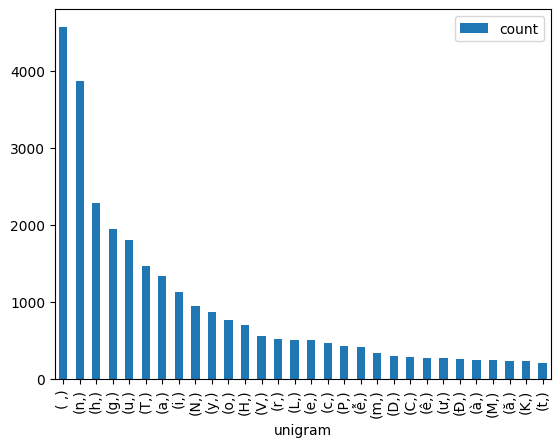

In [49]:
viet_unifd = pd.DataFrame.from_dict(viet_unifreqdist)
viet_unifd.rename(columns={0: 'unigram', 1: 'count'}, inplace=True)
viet_unifd.plot(x="unigram", y="count", kind="bar") 

<Axes: xlabel='bigram'>

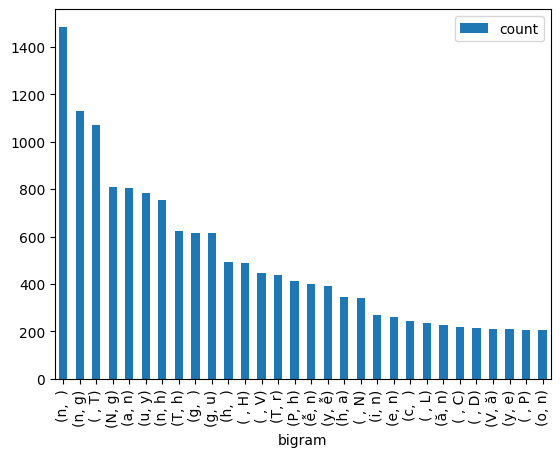

In [50]:
viet_bifreqdist = nltk.FreqDist(viet_bi).most_common(30)
viet_bifd = pd.DataFrame.from_dict(viet_bifreqdist)
viet_bifd.rename(columns={0: 'bigram', 1: 'count'}, inplace=True)
viet_bifd.plot(x="bigram", y="count", kind="bar") 

<Axes: xlabel='trigram'>

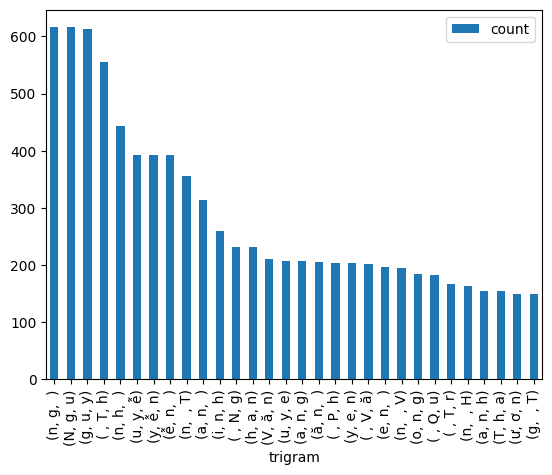

In [51]:
viet_trifreqdist = nltk.FreqDist(viet_tri).most_common(30)
viet_trifd = pd.DataFrame.from_dict(viet_trifreqdist)
viet_trifd.rename(columns={0: 'trigram', 1: 'count'}, inplace=True)
viet_trifd.plot(x="trigram", y="count", kind="bar") 

In [52]:
#todo: do it with relative frequency out of the whole dataset

In [53]:
#How many total unigrams/bigrams/trigrams across the whole dataset? - viet_df

In [54]:
all_unigrams = [unigram for row in viet_df['unigrams'] for unigram in row]
total_unigrams = len(all_unigrams)
print(f"Total number of unigrams (viet_df): {total_unigrams}")

Total number of unigrams (viet_df): 32024


In [55]:
all_bigrams = [bigram for row in viet_df['bigrams'] for bigram in row]
total_bigrams = len(all_bigrams)
print(f"Total number of bigrams (viet_df): {total_bigrams}")

Total number of bigrams (viet_df): 29654


In [56]:
all_trigrams = [trigram for row in viet_df['trigrams'] for trigram in row]
total_trigrams = len(all_trigrams)
print(f"Total number of trigrams (viet_df): {total_trigrams}")

Total number of trigrams (viet_df): 27284


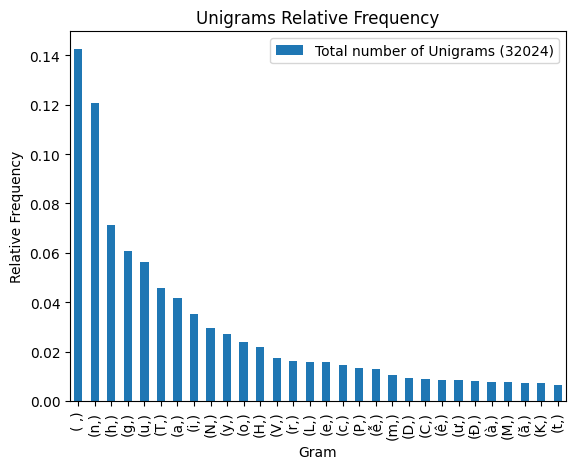

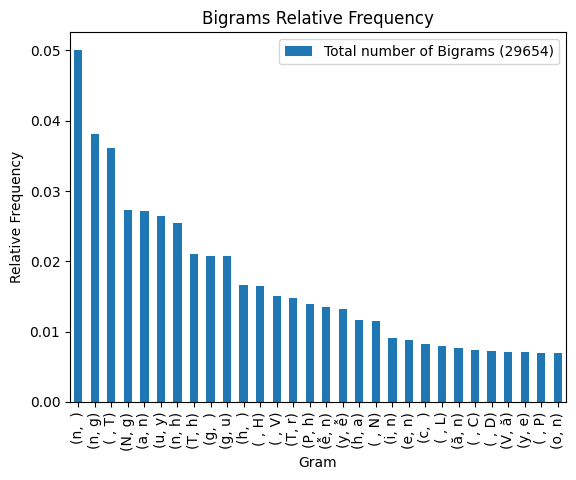

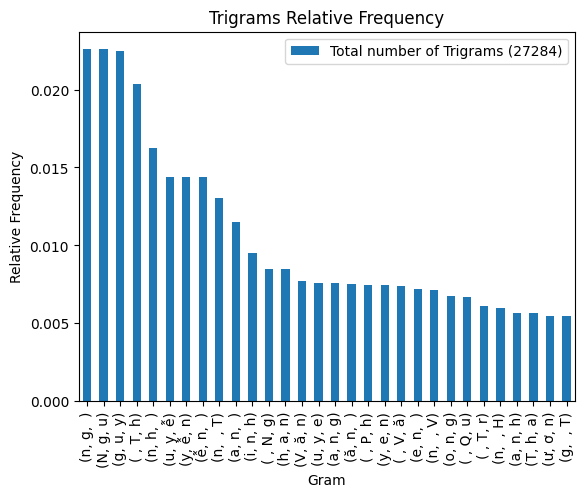

In [57]:
def create_gram_frequency_hashmap(df, col_name):
    gram_freqs = {}
    total_grams = 0

    for grams_list in df[col_name]:
        for gram in grams_list:
            if len(gram) == 1 or len(gram) == 2 or len(gram) == 3:
                if gram not in gram_freqs.keys():
                    gram_freqs[gram] = 1
                else:
                    gram_freqs[gram] += 1
                total_grams += 1

    gram_freqs_relative = {gram: count / total_grams for gram, count in gram_freqs.items()}

    return gram_freqs_relative

viet_unifreqdist_relative = create_gram_frequency_hashmap(viet_df, 'unigrams')
viet_bifreqdist_relative = create_gram_frequency_hashmap(viet_df, 'bigrams')
viet_trifreqdist_relative = create_gram_frequency_hashmap(viet_df, 'trigrams')

def plot_gram_frequency(gram_freq_dist, title, total_grams):
    gram_freq_dist_sorted = sorted(gram_freq_dist.items(), key=lambda x: x[1], reverse=True)
    gram_df_relative = pd.DataFrame(gram_freq_dist_sorted, columns=['gram', 'relative_frequency'])
    top_30_gram_df_relative = gram_df_relative[:30]
    ax = top_30_gram_df_relative.set_index('gram').plot(kind="bar", title=title)
    ax.legend([f"Total number of {title.split()[0].capitalize()} ({total_grams})"])
    plt.xlabel('Gram')
    plt.ylabel('Relative Frequency')
    plt.show()

total_unigrams = 32024
total_bigrams = 29654
total_trigrams = 27284

plot_gram_frequency(viet_unifreqdist_relative, 'Unigrams Relative Frequency', total_unigrams)
plot_gram_frequency(viet_bifreqdist_relative, 'Bigrams Relative Frequency', total_bigrams)
plot_gram_frequency(viet_trifreqdist_relative, 'Trigrams Relative Frequency', total_trigrams)

NEW FREQUENCY DISTRIBUTION + COSINE SIMILARITY WORK
---

In [58]:
#ALL NEW FREQ DIST STUFF + COSINE

In [59]:
def create_lang_char_distribution(df, col_name):
    char_freqs = {}
    total_num_chars = 0  # across the entire language/dataset

    for name in df[col_name]:
        for char in name:
            if char not in char_freqs.keys():
                char_freqs[char] = 1
            else:
                char_freqs[char] += 1
            total_num_chars += 1

    char_freqs_relative = dict(sorted({char: count / total_num_chars for char, count in char_freqs.items()}.items()))
    return char_freqs_relative

def initialize_all_possible_bigrams(all_possible_chars):
    all_possible_bigrams = {}
    for first_char in all_possible_chars:  # first character of the current bigram
        for second_char in all_possible_chars:  # second character of the current bigram
            all_possible_bigrams[(first_char, second_char)] = 0
    return all_possible_bigrams

def create_lang_gram_distribution(initialized_grams, df, col_name):
    gram_freqs = initialized_grams.copy()  # need a copy otherwise initiailized_grams is changed
    total_num_grams = 0  # across the entire language/dataset
    
    for grams_list in df[col_name]:
        for gram in grams_list:
            gram_freqs[gram] += 1
            total_num_grams += 1
    
    gram_freqs_relative = {gram: count / total_num_grams for gram, count in gram_freqs.items()}
    return gram_freqs_relative

def initialize_all_possible_trigrams(all_possible_chars):
    all_possible_trigrams = {}
    for first_char in all_possible_chars:  # first character of the current trigram
        for second_char in all_possible_chars:  # second character of the current trigram
            for third_char in all_possible_chars:  # third character of the current trigram
                all_possible_trigrams[(first_char, second_char, third_char)] = 0
    return all_possible_trigrams

In [60]:
unigram_fdist = create_lang_char_distribution(viet_df, 'fullname')
print(len(unigram_fdist))
unigram_fdist

136


{' ': 0.14258056457656756,
 "'": 6.245316012990258e-05,
 '(': 0.0016862353235073695,
 ')': 0.0016862353235073695,
 ',': 9.367974019485386e-05,
 '-': 0.0004996252810392206,
 '.': 0.00021858606045465902,
 '1': 0.0002498126405196103,
 '2': 3.122658006495129e-05,
 '5': 3.122658006495129e-05,
 '7': 9.367974019485386e-05,
 '8': 6.245316012990258e-05,
 '9': 0.00034349238071446417,
 'A': 0.0032163377466899825,
 'B': 0.006120409692730452,
 'C': 0.00877466899825131,
 'D': 0.009430427179615288,
 'E': 0.0003122658006495129,
 'F': 0.00021858606045465902,
 'G': 0.001967274544091931,
 'H': 0.021827379465400948,
 'I': 0.00034349238071446417,
 'J': 0.0005620784411691232,
 'K': 0.007150886834873845,
 'L': 0.0158318760929303,
 'M': 0.007744191856107919,
 'N': 0.029665251061703722,
 'O': 0.00021858606045465902,
 'P': 0.013489882588058956,
 'Q': 0.0064639020734449165,
 'R': 0.00018735948038970773,
 'S': 0.0034036972270796904,
 'T': 0.04577816637521859,
 'U': 0.0002498126405196103,
 'V': 0.01758056457656757

In [61]:
initialized_bigrams = initialize_all_possible_bigrams(unigram_fdist.keys())
initialized_bigrams

{(' ', ' '): 0,
 (' ', "'"): 0,
 (' ', '('): 0,
 (' ', ')'): 0,
 (' ', ','): 0,
 (' ', '-'): 0,
 (' ', '.'): 0,
 (' ', '1'): 0,
 (' ', '2'): 0,
 (' ', '5'): 0,
 (' ', '7'): 0,
 (' ', '8'): 0,
 (' ', '9'): 0,
 (' ', 'A'): 0,
 (' ', 'B'): 0,
 (' ', 'C'): 0,
 (' ', 'D'): 0,
 (' ', 'E'): 0,
 (' ', 'F'): 0,
 (' ', 'G'): 0,
 (' ', 'H'): 0,
 (' ', 'I'): 0,
 (' ', 'J'): 0,
 (' ', 'K'): 0,
 (' ', 'L'): 0,
 (' ', 'M'): 0,
 (' ', 'N'): 0,
 (' ', 'O'): 0,
 (' ', 'P'): 0,
 (' ', 'Q'): 0,
 (' ', 'R'): 0,
 (' ', 'S'): 0,
 (' ', 'T'): 0,
 (' ', 'U'): 0,
 (' ', 'V'): 0,
 (' ', 'W'): 0,
 (' ', 'X'): 0,
 (' ', 'Y'): 0,
 (' ', 'a'): 0,
 (' ', 'b'): 0,
 (' ', 'c'): 0,
 (' ', 'd'): 0,
 (' ', 'e'): 0,
 (' ', 'f'): 0,
 (' ', 'g'): 0,
 (' ', 'h'): 0,
 (' ', 'i'): 0,
 (' ', 'j'): 0,
 (' ', 'k'): 0,
 (' ', 'l'): 0,
 (' ', 'm'): 0,
 (' ', 'n'): 0,
 (' ', 'o'): 0,
 (' ', 'p'): 0,
 (' ', 'r'): 0,
 (' ', 's'): 0,
 (' ', 't'): 0,
 (' ', 'u'): 0,
 (' ', 'v'): 0,
 (' ', 'w'): 0,
 (' ', 'x'): 0,
 (' ', 'y'): 0,
 (' ', '

In [62]:
# Creating the bigrams frequency distribution for the entire Indonesian language
bigram_fdist = create_lang_gram_distribution(initialized_bigrams, viet_df, 'bigrams')
bigram_fdist

{(' ', ' '): 0.0,
 (' ', "'"): 0.0,
 (' ', '('): 0.001821002225669387,
 (' ', ')'): 0.0,
 (' ', ','): 0.0,
 (' ', '-'): 0.0,
 (' ', '.'): 0.0,
 (' ', '1'): 0.00020233358062993187,
 (' ', '2'): 0.0,
 (' ', '5'): 0.0,
 (' ', '7'): 0.0,
 (' ', '8'): 0.0,
 (' ', '9'): 6.744452687664396e-05,
 (' ', 'A'): 0.0027652256019424022,
 (' ', 'B'): 0.004181560666351926,
 (' ', 'C'): 0.007317731166115869,
 (' ', 'D'): 0.007182842112362582,
 (' ', 'E'): 0.0001686113171916099,
 (' ', 'F'): 0.0,
 (' ', 'G'): 0.0013488905375328793,
 (' ', 'H'): 0.01652390908477777,
 (' ', 'I'): 0.0001686113171916099,
 (' ', 'J'): 0.0,
 (' ', 'K'): 0.006508396843596142,
 (' ', 'L'): 0.007891009644567343,
 (' ', 'M'): 0.005968840628582991,
 (' ', 'N'): 0.011566736359344439,
 (' ', 'O'): 0.00020233358062993187,
 (' ', 'P'): 0.00698050853173265,
 (' ', 'Q'): 0.0062386187360895665,
 (' ', 'R'): 0.0001686113171916099,
 (' ', 'S'): 0.003203615026640588,
 (' ', 'T'): 0.036082821879004516,
 (' ', 'U'): 0.00020233358062993187,
 ('

In [63]:
all_possible_chars_translit = create_lang_char_distribution(viet_df, 'transliteration').keys()
print(len(all_possible_chars_translit))
initialized_trigrams = initialize_all_possible_trigrams(all_possible_chars_translit)
print(len(initialized_trigrams))
initialized_trigrams

63
250047


{(' ', ' ', ' '): 0,
 (' ', ' ', "'"): 0,
 (' ', ' ', '('): 0,
 (' ', ' ', ')'): 0,
 (' ', ' ', ','): 0,
 (' ', ' ', '-'): 0,
 (' ', ' ', '.'): 0,
 (' ', ' ', '1'): 0,
 (' ', ' ', '2'): 0,
 (' ', ' ', '5'): 0,
 (' ', ' ', '7'): 0,
 (' ', ' ', '8'): 0,
 (' ', ' ', '9'): 0,
 (' ', ' ', 'A'): 0,
 (' ', ' ', 'B'): 0,
 (' ', ' ', 'C'): 0,
 (' ', ' ', 'D'): 0,
 (' ', ' ', 'E'): 0,
 (' ', ' ', 'F'): 0,
 (' ', ' ', 'G'): 0,
 (' ', ' ', 'H'): 0,
 (' ', ' ', 'I'): 0,
 (' ', ' ', 'J'): 0,
 (' ', ' ', 'K'): 0,
 (' ', ' ', 'L'): 0,
 (' ', ' ', 'M'): 0,
 (' ', ' ', 'N'): 0,
 (' ', ' ', 'O'): 0,
 (' ', ' ', 'P'): 0,
 (' ', ' ', 'Q'): 0,
 (' ', ' ', 'R'): 0,
 (' ', ' ', 'S'): 0,
 (' ', ' ', 'T'): 0,
 (' ', ' ', 'U'): 0,
 (' ', ' ', 'V'): 0,
 (' ', ' ', 'W'): 0,
 (' ', ' ', 'X'): 0,
 (' ', ' ', 'Y'): 0,
 (' ', ' ', 'a'): 0,
 (' ', ' ', 'b'): 0,
 (' ', ' ', 'c'): 0,
 (' ', ' ', 'd'): 0,
 (' ', ' ', 'e'): 0,
 (' ', ' ', 'f'): 0,
 (' ', ' ', 'g'): 0,
 (' ', ' ', 'h'): 0,
 (' ', ' ', 'i'): 0,
 (' ', ' ', '

In [64]:
viet_df['trigrams'] = viet_df['transliteration'].apply(lambda name: list(ngrams(list(name), 3)))
trigram_fdist = create_lang_gram_distribution(initialized_trigrams, viet_df, 'trigrams')
trigram_fdist

{(' ', ' ', ' '): 0.0,
 (' ', ' ', "'"): 0.0,
 (' ', ' ', '('): 0.0,
 (' ', ' ', ')'): 0.0,
 (' ', ' ', ','): 0.0,
 (' ', ' ', '-'): 0.0,
 (' ', ' ', '.'): 0.0,
 (' ', ' ', '1'): 0.0,
 (' ', ' ', '2'): 0.0,
 (' ', ' ', '5'): 0.0,
 (' ', ' ', '7'): 0.0,
 (' ', ' ', '8'): 0.0,
 (' ', ' ', '9'): 0.0,
 (' ', ' ', 'A'): 0.0,
 (' ', ' ', 'B'): 0.0,
 (' ', ' ', 'C'): 0.0,
 (' ', ' ', 'D'): 0.0,
 (' ', ' ', 'E'): 0.0,
 (' ', ' ', 'F'): 0.0,
 (' ', ' ', 'G'): 0.0,
 (' ', ' ', 'H'): 0.0,
 (' ', ' ', 'I'): 0.0,
 (' ', ' ', 'J'): 0.0,
 (' ', ' ', 'K'): 0.0,
 (' ', ' ', 'L'): 0.0,
 (' ', ' ', 'M'): 0.0,
 (' ', ' ', 'N'): 0.0,
 (' ', ' ', 'O'): 0.0,
 (' ', ' ', 'P'): 0.0,
 (' ', ' ', 'Q'): 0.0,
 (' ', ' ', 'R'): 0.0,
 (' ', ' ', 'S'): 0.0,
 (' ', ' ', 'T'): 0.0,
 (' ', ' ', 'U'): 0.0,
 (' ', ' ', 'V'): 0.0,
 (' ', ' ', 'W'): 0.0,
 (' ', ' ', 'X'): 0.0,
 (' ', ' ', 'Y'): 0.0,
 (' ', ' ', 'a'): 0.0,
 (' ', ' ', 'b'): 0.0,
 (' ', ' ', 'c'): 0.0,
 (' ', ' ', 'd'): 0.0,
 (' ', ' ', 'e'): 0.0,
 (' ', ' ',

In [65]:
# Now: Individual Relative Frequency Distributions

In [66]:
initialized_unigrams = {char: 0 for char in unigram_fdist.keys()}
# initialized_unigrams

In [67]:
# viet_df.iloc[0]

In [68]:
def create_indiv_gram_distribution(grams_list, initialized_grams):
    gram_freqs_relative = initialized_grams.copy()
    num_grams = len(grams_list)

    for gram in grams_list:
        # Use the get method to safely increment the count or initialize it to 0 if not present
        gram_freqs_relative[gram] = gram_freqs_relative.get(gram, 0) + 1 / num_grams

    return gram_freqs_relative

# UNIGRAMS individual frequency distributions
viet_df['indiv_unigrams_fdist'] = viet_df['unigrams'].apply(lambda grams_list: create_indiv_gram_distribution(grams_list, initialized_unigrams))
print(viet_df.iloc[0]['indiv_unigrams_fdist'])

In [69]:
# BIGRAMS individual frequency distributions
viet_df['indiv_bigrams_fdist'] = viet_df['bigrams'].apply(lambda grams_list: create_indiv_gram_distribution(grams_list, initialized_bigrams))
print(viet_df.iloc[0]['indiv_bigrams_fdist'][('T', 'ừ')])
print(1 / len(viet_df.iloc[0]['bigrams']))

0.07692307692307693
0.07692307692307693


In [70]:
#Todo: for trigrams

In [71]:
#TODO: COSINE SIMILARITY for each of viet things